In [246]:
# Data manipulation
import pandas as pd
import numpy as np
import pyarrow

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

# Plot aesthetics
color_pal = sns.color_palette()
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb  # ML algorithm for forecasting
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Error metrics

In [247]:
import time

# Record the start time
start_time = time.time()

Referenced from: https://github.com/jpsam07/skyline-hospital-time-series-forecasting-with-xgboost?tab=readme-ov-file#data-collection

In [248]:
filepath = 'sample-data/term_dates_parking.csv' # change as needed

df = pd.read_csv(filepath)

df.head()


,Timestamp,North,West,Rose,Health Sciences,Fraser,Thunderbird,University Lot Blvd,temp,visibility,dew_point,feels_like,pressure,humidity,wind_speed,clouds_all,rain_1h,snow_1h,term_date,is_holiday
0,2018-09-06 10:00:00,951,1016,476,913,556,939,-1,14.59,10000.0,10.21,14.06,1015,75,1.03,20,NaN,NaN,False,False
1,2018-09-06 11:00:00,922,1160,609,972,707,1050,-1,14.01,10000.0,9.85,13.45,1016,76,0.00,40,NaN,NaN,False,False
2,2018-09-06 12:00:00,833,1206,659,963,724,1072,-1,14.16,10000.0,10.58,13.69,1016,79,2.10,75,NaN,NaN,False,False
3,2018-09-06 13:00:00,851,1168,695,953,719,1094,-1,13.85,10000.0,9.70,13.28,1016,76,2.10,30,NaN,NaN,False,False
4,2018-09-06 14:00:00,857,1220,710,963,727,1069,-1,13.96,10000.0,9.41,13.34,1017,74,2.60,75,NaN,NaN,False,False


In [249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36158 entries, 0 to 36157
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Timestamp            36158 non-null  object 
 1   North                36158 non-null  int64  
 2   West                 36158 non-null  int64  
 3   Rose                 36158 non-null  int64  
 4   Health Sciences      36158 non-null  int64  
 5   Fraser               36158 non-null  int64  
 6   Thunderbird          36158 non-null  int64  
 7   University Lot Blvd  36158 non-null  int64  
 8   temp                 36158 non-null  float64
 9   visibility           32468 non-null  float64
 10  dew_point            36158 non-null  float64
 11  feels_like           36158 non-null  float64
 12  pressure             36158 non-null  int64  
 13  humidity             36158 non-null  int64  
 14  wind_speed           36158 non-null  float64
 15  clouds_all           36158 non-null 

In [250]:
df.rename(columns={'Timestamp': 'date'}, inplace=True)
df = df.set_index('date')
df

,North,West,Rose,Health Sciences,Fraser,Thunderbird,University Lot Blvd,temp,visibility,dew_point,feels_like,pressure,humidity,wind_speed,clouds_all,rain_1h,snow_1h,term_date,is_holiday
date,,,,,,,,,,,,,,,,,,,
2018-09-06 10:00:00,951,1016,476,913,556,939,-1,14.59,10000.0,10.21,14.06,1015,75,1.03,20,NaN,NaN,False,False
2018-09-06 11:00:00,922,1160,609,972,707,1050,-1,14.01,10000.0,9.85,13.45,1016,76,0.00,40,NaN,NaN,False,False
2018-09-06 12:00:00,833,1206,659,963,724,1072,-1,14.16,10000.0,10.58,13.69,1016,79,2.10,75,NaN,NaN,False,False
2018-09-06 13:00:00,851,1168,695,953,719,1094,-1,13.85,10000.0,9.70,13.28,1016,76,2.10,30,NaN,NaN,False,False
2018-09-06 14:00:00,857,1220,710,963,727,1069,-1,13.96,10000.0,9.41,13.34,1017,74,2.60,75,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-05 19:00:00,72,232,154,172,119,217,64,3.21,10000.0,-0.53,1.22,1017,76,2.06,75,NaN,NaN,False,False
2024-03-05 20:00:00,10,146,100,91,70,164,43,4.18,10000.0,-1.41,0.78,1018,66,4.12,20,NaN,NaN,False,False
2024-03-05 21:00:00,0,88,44,62,43,121,34,4.17,10000.0,-1.06,0.49,1018,68,4.63,20,NaN,NaN,False,False


In [251]:
# Convert sensor columns to numeric (in case they are not already)
# df['sensor'] = df.iloc[:, 0:10].mean(axis=1)
#df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Calculate the average across sensor columns
# df['sensor'] = df.iloc[:, 1:].mean(axis=1)

# Drop the individual sensor columns
# df.drop(columns=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], inplace=True)

# Display the updated DataFrame
parking_lot_to_predict = 'West'
df.rename(columns={parking_lot_to_predict: 'Occupancy'}, inplace=True)

parking_lots = ['North','West', 'Rose', 'Health Sciences', 'Fraser', 'Thunderbird', 'University Lot Blvd']

parking_lots.remove(parking_lot_to_predict)
df.drop(columns=parking_lots, inplace=True)
print(df.head())


                     Occupancy   temp  visibility  dew_point  feels_like  \
date                                                                       
2018-09-06 10:00:00       1016  14.59     10000.0      10.21       14.06   
2018-09-06 11:00:00       1160  14.01     10000.0       9.85       13.45   
2018-09-06 12:00:00       1206  14.16     10000.0      10.58       13.69   
2018-09-06 13:00:00       1168  13.85     10000.0       9.70       13.28   
2018-09-06 14:00:00       1220  13.96     10000.0       9.41       13.34   

                     pressure  humidity  wind_speed  clouds_all  rain_1h  \
date                                                                       
2018-09-06 10:00:00      1015        75        1.03          20      NaN   
2018-09-06 11:00:00      1016        76        0.00          40      NaN   
2018-09-06 12:00:00      1016        79        2.10          75      NaN   
2018-09-06 13:00:00      1016        76        2.10          30      NaN   
2018-09-06 

In [252]:
old_df = df
# Calculate the 95th percentile of the 'Occupancy' column
threshold = df['Occupancy'].quantile(1)

# Filter the DataFrame to exclude values above the threshold
df = df[df['Occupancy'] <= threshold]

# Filter the DataFrame to exclude values above the threshold
df = df[df['Occupancy'] >= 0]

# Display the filtered DataFrame
print(df)

                     Occupancy   temp  visibility  dew_point  feels_like  \
date                                                                       
2018-09-06 10:00:00       1016  14.59     10000.0      10.21       14.06   
2018-09-06 11:00:00       1160  14.01     10000.0       9.85       13.45   
2018-09-06 12:00:00       1206  14.16     10000.0      10.58       13.69   
2018-09-06 13:00:00       1168  13.85     10000.0       9.70       13.28   
2018-09-06 14:00:00       1220  13.96     10000.0       9.41       13.34   
...                        ...    ...         ...        ...         ...   
2024-03-05 19:00:00        232   3.21     10000.0      -0.53        1.22   
2024-03-05 20:00:00        146   4.18     10000.0      -1.41        0.78   
2024-03-05 21:00:00         88   4.17     10000.0      -1.06        0.49   
2024-03-05 22:00:00         64   4.57     10000.0      -1.45        1.26   
2024-03-05 23:00:00         41   4.68     10000.0      -1.55        2.46   

           

In [253]:
df = df.copy()
df['date'] = pd.to_datetime(df.index)
df['day_of_week'] = df['date'].dt.dayofweek
print(df.head())

print(df.tail())

                     Occupancy   temp  visibility  dew_point  feels_like  \
date                                                                       
2018-09-06 10:00:00       1016  14.59     10000.0      10.21       14.06   
2018-09-06 11:00:00       1160  14.01     10000.0       9.85       13.45   
2018-09-06 12:00:00       1206  14.16     10000.0      10.58       13.69   
2018-09-06 13:00:00       1168  13.85     10000.0       9.70       13.28   
2018-09-06 14:00:00       1220  13.96     10000.0       9.41       13.34   

                     pressure  humidity  wind_speed  clouds_all  rain_1h  \
date                                                                       
2018-09-06 10:00:00      1015        75        1.03          20      NaN   
2018-09-06 11:00:00      1016        76        0.00          40      NaN   
2018-09-06 12:00:00      1016        79        2.10          75      NaN   
2018-09-06 13:00:00      1016        76        2.10          30      NaN   
2018-09-06 

<Axes: xlabel='day_of_week'>

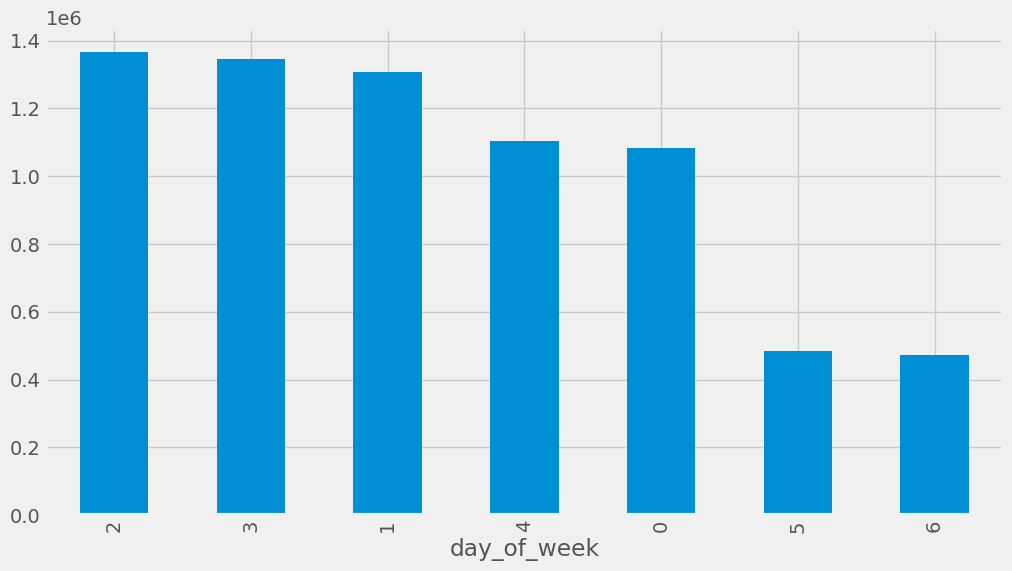

In [254]:
df.groupby('day_of_week')['Occupancy'].sum().sort_values(ascending=False) \
    .plot(kind='bar', figsize=(11, 6))


In [255]:
import pandas as pd

# Ensure the date column is in datetime format (assuming the date column is named 'date')
df['date'] = pd.to_datetime(df['date'])

# Define the date range (assuming the year spans across December to January)
start_date = pd.to_datetime('2023-12-20')
end_date = pd.to_datetime('2024-01-05')

# Filter the data
filtered_df = df.loc[(df['date'] >= start_date) & (df['date'] <= end_date)]

# Display the filtered data
filtered_df


,Occupancy,temp,visibility,dew_point,feels_like,pressure,humidity,wind_speed,clouds_all,rain_1h,snow_1h,term_date,is_holiday,date,day_of_week
date,,,,,,,,,,,,,,,
2023-12-20 00:00:00,17,9.82,10000.0,9.21,8.24,1003,96,3.09,100,0.59,NaN,False,False,2023-12-20 00:00:00,2
2023-12-20 01:00:00,8,9.54,9656.0,8.93,7.63,1004,96,3.60,100,0.25,NaN,False,False,2023-12-20 01:00:00,2
2023-12-20 02:00:00,8,9.48,9656.0,9.18,7.31,1005,98,4.12,100,1.53,NaN,False,False,2023-12-20 02:00:00,2
2023-12-20 03:00:00,11,9.45,4828.0,9.00,7.52,1005,97,3.60,100,0.76,NaN,False,False,2023-12-20 03:00:00,2
2023-12-20 04:00:00,9,9.48,2414.0,9.18,7.83,1006,98,3.09,100,1.02,NaN,False,False,2023-12-20 04:00:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-04 20:00:00,33,6.13,8047.0,5.69,3.18,1017,97,4.12,75,1.02,NaN,False,False,2024-01-04 20:00:00,3
2024-01-04 21:00:00,33,6.66,10000.0,6.37,4.13,1017,98,3.58,75,0.46,NaN,False,False,2024-01-04 21:00:00,3
2024-01-04 22:00:00,29,7.30,NaN,6.71,4.67,1018,96,4.02,64,0.29,NaN,False,False,2024-01-04 22:00:00,3


In [256]:
# Remove rows where Occupancy is -1
df = df[df['Occupancy'] != -1]

In [257]:
from statsmodels.tsa.seasonal import STL

In [258]:
import pandas as pd
from statsmodels.tsa.seasonal import STL

# Assuming 'Occupancy' is the column containing the Occupancy data
traffic_series = df['Occupancy']

# Step 1: Ensure the index is a datetime index
df.index = pd.to_datetime(df.index)

# Step 2: Extract 'Occupancy' as a pandas Series
traffic_series = df['Occupancy']



In [259]:

# Step 3: Convert the data type of the Series to numeric (if needed)
traffic_series = pd.to_numeric(traffic_series, errors='coerce')

traffic_series.head()




date
2018-09-06 10:00:00    1016
2018-09-06 11:00:00    1160
2018-09-06 12:00:00    1206
2018-09-06 13:00:00    1168
2018-09-06 14:00:00    1220
Name: Occupancy, dtype: int64

In [260]:
traffic_series.tail()

date
2024-03-05 19:00:00    232
2024-03-05 20:00:00    146
2024-03-05 21:00:00     88
2024-03-05 22:00:00     64
2024-03-05 23:00:00     41
Name: Occupancy, dtype: int64

In [261]:
def create_features(df, label=None):
    """
    Create time series features from the datetime index
    """
    df = df.copy()
    df['date'] = df.index
    df['month'] = df['date'].dt.month
    df['day_of_year'] = df['date'].dt.dayofyear
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['day_of_week'] = df['date'].dt.dayofweek
    df['hour'] = df['date'].dt.hour  # Add hour feature

    # Apply weight to the day_of_year column
    weight = 100  # You can adjust this weight as needed
    df['weighted_day_of_year'] = df['day_of_year'] * weight
    
    df['year'] = df['date'].dt.year
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    
    # Seasonality features
    df['sin_day'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    df['cos_day'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
    df['sin_week'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['cos_week'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

    # Seasonal indices (if applicable)
    # Autoregressive features (if applicable)
    # Time since last event (if applicable)
    # Day/night indicator
    df['is_day'] = np.where((df['hour'] >= 6) & (df['hour'] <= 18), 1, 0)
    
    # Weekend/weekday indicator
    df['is_weekend'] = df.date.dt.weekday // 4
    
    # Month of year
    df['month_of_year'] = df['date'].dt.month
    
    # Quarter of year
    df['quarter_of_year'] = df['date'].dt.quarter
    
    # Day/night duration
    df['day_duration'] = np.where(df['is_day'] == 1, 12 - df['hour'], 0)
    df['night_duration'] = np.where(df['is_day'] == 0, df['hour'], 0)
    
    # Weather data (if available)
    # Special event indicators (if applicable)
    # Trend features (if applicable)
    
    return df

def create_rolling_calculation_features(df, label=None):
    df = df.copy()
    window_sizes = [24, 7 * 24]  # 7-day rolling window (168 hours)
    shift_size = 7 * 24       # Shift size (1 day or 24 hours)

    # Shift the data before applying the rolling window
    shifted_occupancy = df['Occupancy'].shift(shift_size)

    for window_size in window_sizes:
        # Rolling minimum
        df[f'rolling_min_{window_size}'] = shifted_occupancy.rolling(window=window_size).min()
        
        # Rolling maximum
        df[f'rolling_max_{window_size}'] = shifted_occupancy.rolling(window=window_size).max()
        
        # Rolling sum
        df[f'rolling_sum_{window_size}'] = shifted_occupancy.rolling(window=window_size).sum()
        
        # Rolling mean
        df[f'rolling_mean_{window_size}'] = shifted_occupancy.rolling(window=window_size).mean()
        
        # Rolling median
        df[f'rolling_median_{window_size}'] = shifted_occupancy.rolling(window=window_size).median()
        
        # Rolling standard deviation
        df[f'rolling_std_{window_size}'] = shifted_occupancy.rolling(window=window_size).std()
        
        # Rolling 25th percentile
        df[f'rolling_quantile_25_{window_size}'] = shifted_occupancy.rolling(window=window_size).quantile(0.25)
        
        # Rolling 75th percentile
        df[f'rolling_quantile_75_{window_size}'] = shifted_occupancy.rolling(window=window_size).quantile(0.75)
        
    return df

# Example usage
df = create_features(df)
#df = create_rolling_calculation_features(df)
df.dtypes


Occupancy                        int64
temp                           float64
visibility                     float64
dew_point                      float64
feels_like                     float64
pressure                         int64
humidity                         int64
wind_speed                     float64
clouds_all                       int64
rain_1h                        float64
snow_1h                        float64
term_date                         bool
is_holiday                        bool
date                    datetime64[ns]
day_of_week                      int32
month                            int32
day_of_year                      int32
week_of_year                    UInt32
hour                             int32
weighted_day_of_year             int32
year                             int32
is_month_start                   int32
is_month_end                     int32
sin_day                        float64
cos_day                        float64
sin_week                 

In [262]:
# Replace negative values in 'Occupancy' column with 0
df.loc[df['Occupancy'] < 0, 'Occupancy'] = 0


In [263]:
from sklearn.model_selection import TimeSeriesSplit

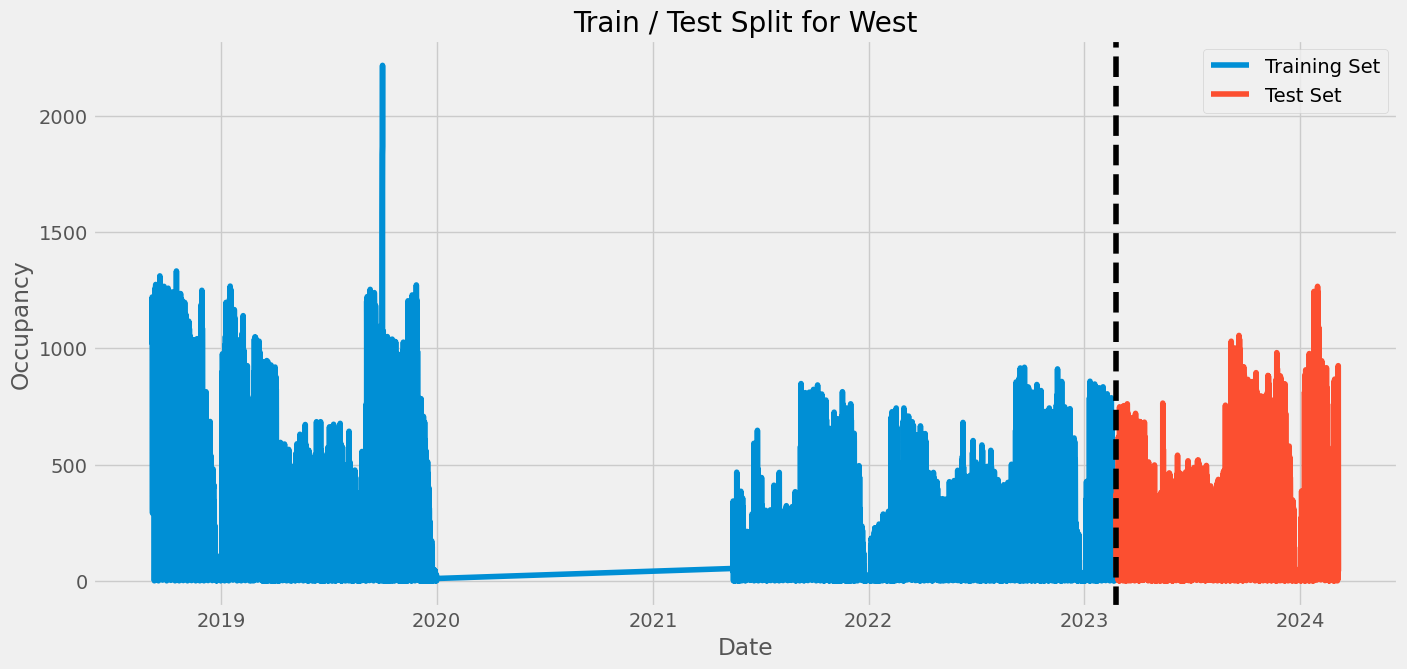

In [264]:
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame
train_size = 0.75
train, test = train_test_split(df, test_size=(1 - train_size), shuffle=False)

# Plotting the data
plt.figure(figsize=(15, 7))
plt.plot(train.index, train['Occupancy'], label='Training Set')
plt.plot(test.index, test['Occupancy'], label='Test Set')
plt.axvline(test.index.min(), color='black', ls='--')
plt.title(f'Train / Test Split for {parking_lot_to_predict}')
plt.xlabel('Date')
plt.ylabel('Occupancy')
plt.legend()
plt.show()


In [265]:
df

,Occupancy,temp,visibility,dew_point,feels_like,pressure,humidity,wind_speed,clouds_all,rain_1h,...,sin_week,cos_week,sin_month,cos_month,is_day,is_weekend,month_of_year,quarter_of_year,day_duration,night_duration
date,,,,,,,,,,,,,,,,,,,,,
2018-09-06 10:00:00,1016,14.59,10000.0,10.21,14.06,1015,75,1.03,20,NaN,...,0.433884,-0.900969,-1.0,-1.836970e-16,1,0,9,3,2,0
2018-09-06 11:00:00,1160,14.01,10000.0,9.85,13.45,1016,76,0.00,40,NaN,...,0.433884,-0.900969,-1.0,-1.836970e-16,1,0,9,3,1,0
2018-09-06 12:00:00,1206,14.16,10000.0,10.58,13.69,1016,79,2.10,75,NaN,...,0.433884,-0.900969,-1.0,-1.836970e-16,1,0,9,3,0,0
2018-09-06 13:00:00,1168,13.85,10000.0,9.70,13.28,1016,76,2.10,30,NaN,...,0.433884,-0.900969,-1.0,-1.836970e-16,1,0,9,3,-1,0
2018-09-06 14:00:00,1220,13.96,10000.0,9.41,13.34,1017,74,2.60,75,NaN,...,0.433884,-0.900969,-1.0,-1.836970e-16,1,0,9,3,-2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-05 19:00:00,232,3.21,10000.0,-0.53,1.22,1017,76,2.06,75,NaN,...,0.781831,0.623490,1.0,6.123234e-17,0,0,3,1,0,19
2024-03-05 20:00:00,146,4.18,10000.0,-1.41,0.78,1018,66,4.12,20,NaN,...,0.781831,0.623490,1.0,6.123234e-17,0,0,3,1,0,20
2024-03-05 21:00:00,88,4.17,10000.0,-1.06,0.49,1018,68,4.63,20,NaN,...,0.781831,0.623490,1.0,6.123234e-17,0,0,3,1,0,21


In [266]:
def add_lags(df):
    """
    Create time lags for added time series features and allow the model to learn the temporal structure of the data.
    """
    target_map = df['Occupancy'].to_dict()
    """
    df['lag_1_hour'] = (df.index - pd.Timedelta('1 hours')).map(target_map)
    df['lag_2_hours'] = (df.index - pd.Timedelta('2 hours')).map(target_map)
    """

    """
    for lag_hours in range(3, 25):  # lags for 1 to 24 hours
        df[f'lag_{lag_hours}_hours'] = (df.index - pd.Timedelta(f'{lag_hours} hours')).map(target_map)

    """

    
    for lag_days in range(1, 20):  # lags for 1 to 6 days
        df[f'lag_{lag_days*7}_days'] = (df.index - pd.Timedelta(f'{lag_days*7} days')).map(target_map)
    
    
     # Daily lags
    
    for lag_days in range(1, 7):  # lags for 1 to 6 days
        df[f'lag_{lag_days}_days'] = (df.index - pd.Timedelta(f'{lag_days} days')).map(target_map)
    
    return df

df = add_lags(df)
df

,Occupancy,temp,visibility,dew_point,feels_like,pressure,humidity,wind_speed,clouds_all,rain_1h,...,lag_112_days,lag_119_days,lag_126_days,lag_133_days,lag_1_days,lag_2_days,lag_3_days,lag_4_days,lag_5_days,lag_6_days
date,,,,,,,,,,,,,,,,,,,,,
2018-09-06 10:00:00,1016,14.59,10000.0,10.21,14.06,1015,75,1.03,20,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-06 11:00:00,1160,14.01,10000.0,9.85,13.45,1016,76,0.00,40,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-06 12:00:00,1206,14.16,10000.0,10.58,13.69,1016,79,2.10,75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-06 13:00:00,1168,13.85,10000.0,9.70,13.28,1016,76,2.10,30,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-06 14:00:00,1220,13.96,10000.0,9.41,13.34,1017,74,2.60,75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-05 19:00:00,232,3.21,10000.0,-0.53,1.22,1017,76,2.06,75,NaN,...,80.0,240.0,146.0,210.0,211.0,17.0,62.0,121.0,222.0,246.0
2024-03-05 20:00:00,146,4.18,10000.0,-1.41,0.78,1018,66,4.12,20,NaN,...,41.0,154.0,79.0,138.0,138.0,18.0,47.0,101.0,146.0,168.0
2024-03-05 21:00:00,88,4.17,10000.0,-1.06,0.49,1018,68,4.63,20,NaN,...,38.0,88.0,45.0,64.0,91.0,17.0,40.0,78.0,77.0,113.0


In [267]:
df.columns

Index(['Occupancy', 'temp', 'visibility', 'dew_point', 'feels_like',
       'pressure', 'humidity', 'wind_speed', 'clouds_all', 'rain_1h',
       'snow_1h', 'term_date', 'is_holiday', 'date', 'day_of_week', 'month',
       'day_of_year', 'week_of_year', 'hour', 'weighted_day_of_year', 'year',
       'is_month_start', 'is_month_end', 'sin_day', 'cos_day', 'sin_week',
       'cos_week', 'sin_month', 'cos_month', 'is_day', 'is_weekend',
       'month_of_year', 'quarter_of_year', 'day_duration', 'night_duration',
       'lag_7_days', 'lag_14_days', 'lag_21_days', 'lag_28_days',
       'lag_35_days', 'lag_42_days', 'lag_49_days', 'lag_56_days',
       'lag_63_days', 'lag_70_days', 'lag_77_days', 'lag_84_days',
       'lag_91_days', 'lag_98_days', 'lag_105_days', 'lag_112_days',
       'lag_119_days', 'lag_126_days', 'lag_133_days', 'lag_1_days',
       'lag_2_days', 'lag_3_days', 'lag_4_days', 'lag_5_days', 'lag_6_days'],
      dtype='object')

In [268]:
df.dtypes

Occupancy                        int64
temp                           float64
visibility                     float64
dew_point                      float64
feels_like                     float64
pressure                         int64
humidity                         int64
wind_speed                     float64
clouds_all                       int64
rain_1h                        float64
snow_1h                        float64
term_date                         bool
is_holiday                        bool
date                    datetime64[ns]
day_of_week                      int32
month                            int32
day_of_year                      int32
week_of_year                    UInt32
hour                             int32
weighted_day_of_year             int32
year                             int32
is_month_start                   int32
is_month_end                     int32
sin_day                        float64
cos_day                        float64
sin_week                 

In [269]:
df

,Occupancy,temp,visibility,dew_point,feels_like,pressure,humidity,wind_speed,clouds_all,rain_1h,...,lag_112_days,lag_119_days,lag_126_days,lag_133_days,lag_1_days,lag_2_days,lag_3_days,lag_4_days,lag_5_days,lag_6_days
date,,,,,,,,,,,,,,,,,,,,,
2018-09-06 10:00:00,1016,14.59,10000.0,10.21,14.06,1015,75,1.03,20,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-06 11:00:00,1160,14.01,10000.0,9.85,13.45,1016,76,0.00,40,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-06 12:00:00,1206,14.16,10000.0,10.58,13.69,1016,79,2.10,75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-06 13:00:00,1168,13.85,10000.0,9.70,13.28,1016,76,2.10,30,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-06 14:00:00,1220,13.96,10000.0,9.41,13.34,1017,74,2.60,75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-05 19:00:00,232,3.21,10000.0,-0.53,1.22,1017,76,2.06,75,NaN,...,80.0,240.0,146.0,210.0,211.0,17.0,62.0,121.0,222.0,246.0
2024-03-05 20:00:00,146,4.18,10000.0,-1.41,0.78,1018,66,4.12,20,NaN,...,41.0,154.0,79.0,138.0,138.0,18.0,47.0,101.0,146.0,168.0
2024-03-05 21:00:00,88,4.17,10000.0,-1.06,0.49,1018,68,4.63,20,NaN,...,38.0,88.0,45.0,64.0,91.0,17.0,40.0,78.0,77.0,113.0


In [270]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming df is your DataFrame and create_features is a function to generate features
train, test = train_test_split(df, test_size=(1-train_size), shuffle=False)

train = create_features(train)
test = create_features(test)

# Define the target variable and the column to exclude
TARGET = 'Occupancy'
EXCLUDE_COLUMNS = ['date', TARGET]

# Generate the list of features
FEATURES = [col for col in df.columns if col not in EXCLUDE_COLUMNS]
# weather features
# FEATURES = ['temp', 'visibility', 'dew_point', 'feels_like', 'pressure', 'humidity', 'wind_speed', 'clouds_all', 'rain_1h', 'snow_1h', 'weather_Clear_sky is clear', 'weather_Clouds_broken clouds', 'weather_Clouds_few clouds', 'weather_Clouds_overcast clouds', 'weather_Clouds_scattered clouds', 'weather_Drizzle_drizzle', 'weather_Drizzle_light intensity drizzle', 'weather_Drizzle_light intensity drizzle rain', 'weather_Drizzle_rain and drizzle', 'weather_Dust_dust', 'weather_Fog_fog', 'weather_Haze_haze', 'weather_Mist_mist', 'weather_Rain_heavy intensity rain', 'weather_Rain_heavy intensity shower rain', 'weather_Rain_light intensity shower rain', 'weather_Rain_light rain', 'weather_Rain_moderate rain', 'weather_Rain_proximity shower rain', 'weather_Rain_shower rain', 'weather_Rain_very heavy rain', 'weather_Smoke_smoke', 'weather_Snow_heavy snow', 'weather_Snow_light rain and snow', 'weather_Snow_light shower sleet', 'weather_Snow_light shower snow', 'weather_Snow_light snow', 'weather_Snow_sleet', 'weather_Snow_snow', 'weather_Thunderstorm_thunderstorm', 'weather_Thunderstorm_thunderstorm with heavy rain', 'weather_Thunderstorm_thunderstorm with light rain', 'weather_Thunderstorm_thunderstorm with rain']


print(FEATURES)


['temp', 'visibility', 'dew_point', 'feels_like', 'pressure', 'humidity', 'wind_speed', 'clouds_all', 'rain_1h', 'snow_1h', 'term_date', 'is_holiday', 'day_of_week', 'month', 'day_of_year', 'week_of_year', 'hour', 'weighted_day_of_year', 'year', 'is_month_start', 'is_month_end', 'sin_day', 'cos_day', 'sin_week', 'cos_week', 'sin_month', 'cos_month', 'is_day', 'is_weekend', 'month_of_year', 'quarter_of_year', 'day_duration', 'night_duration', 'lag_7_days', 'lag_14_days', 'lag_21_days', 'lag_28_days', 'lag_35_days', 'lag_42_days', 'lag_49_days', 'lag_56_days', 'lag_63_days', 'lag_70_days', 'lag_77_days', 'lag_84_days', 'lag_91_days', 'lag_98_days', 'lag_105_days', 'lag_112_days', 'lag_119_days', 'lag_126_days', 'lag_133_days', 'lag_1_days', 'lag_2_days', 'lag_3_days', 'lag_4_days', 'lag_5_days', 'lag_6_days']


In [271]:

'''
FEATURES = ['hour','day_of_week', 'month', 'day_of_year', 'rolling_min', 'rolling_max',
            'rolling_sum', 'rolling_mean', 'rolling_median', 'rolling_std', 'rolling_quantile_25',
            'rolling_quantile_75', 'lag_7_days', 'lag_14_days', 'lag_21_days', 'lag_28_days', 
            'lag_30_days', 'lag_35_days', 'lag_42_days', 'lag_49_days', 'lag_56_days', 'lag_60_days',
            'lag_1_hour', 'lag_2_hours', 'lag_3_hours',
            'lag_1_days', 'lag_2_days', 'lag_3_days', 'lag_4_days', 'lag_5_days','lag_6_days',
            ] + WEATHER_FEATURES

'''

TARGET = 'Occupancy'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


reg = lgb.LGBMRegressor(boosting_type='gbdt',
                        n_estimators=5000,
                        early_stopping_rounds=20,
                        objective='regression',
                        max_depth=5,
                        min_child_samples=1,
                        learning_rate=0.05,
                        colsample_bytree=0.91,
                        subsample=0.5,
                        reg_lambda=0.2,

                        )

"""
                        num_leaves=50,
                        num_iterations = 200,
                        feature_fraction = 0.4,
                        max_cat_threshold = 1,
                        path_smooth = 10,
                        extra_trees = False
                        """
                        

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

y_pred = reg.predict(X_test)
y_pred = np.maximum(y_pred, 0)

# Store actual and predicted values along with their datetime index in the DataFrame
actual_vs_pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}, index=test.index)


[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9006
[LightGBM] [Info] Number of data points in the train set: 27111, number of used features: 58
[LightGBM] [Warning] early_stopping_round is set=20, early_stopping_rounds=20 will be ignored. Current value: early_stopping_round=20
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 205.57120

In [272]:
actual_vs_pred_df.to_csv(f'lgb_{parking_lot_to_predict}_actual_vs_predicted.csv', index=True)

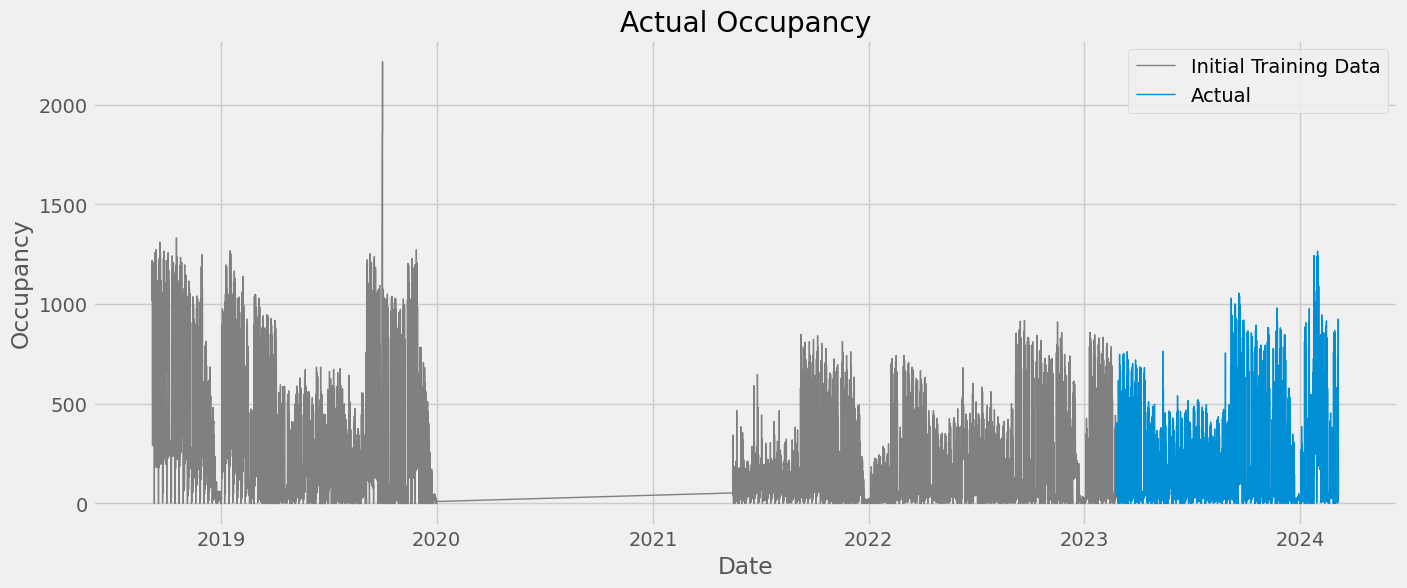

In [273]:
# Create figure
plt.figure(figsize=(15, 6))

# Plot the initial training data
plt.plot(train.index, train['Occupancy'], label='Initial Training Data', color='gray', linewidth=1)

# Plot for the actual and predicted values
plt.plot(actual_vs_pred_df.index, actual_vs_pred_df['Actual'], label='Actual', linewidth=1)

# Plot labels and title
plt.xlabel('Date')
plt.ylabel('Occupancy')
plt.title('Actual Occupancy')

# Show legend
plt.legend()

# Show plot
plt.show()


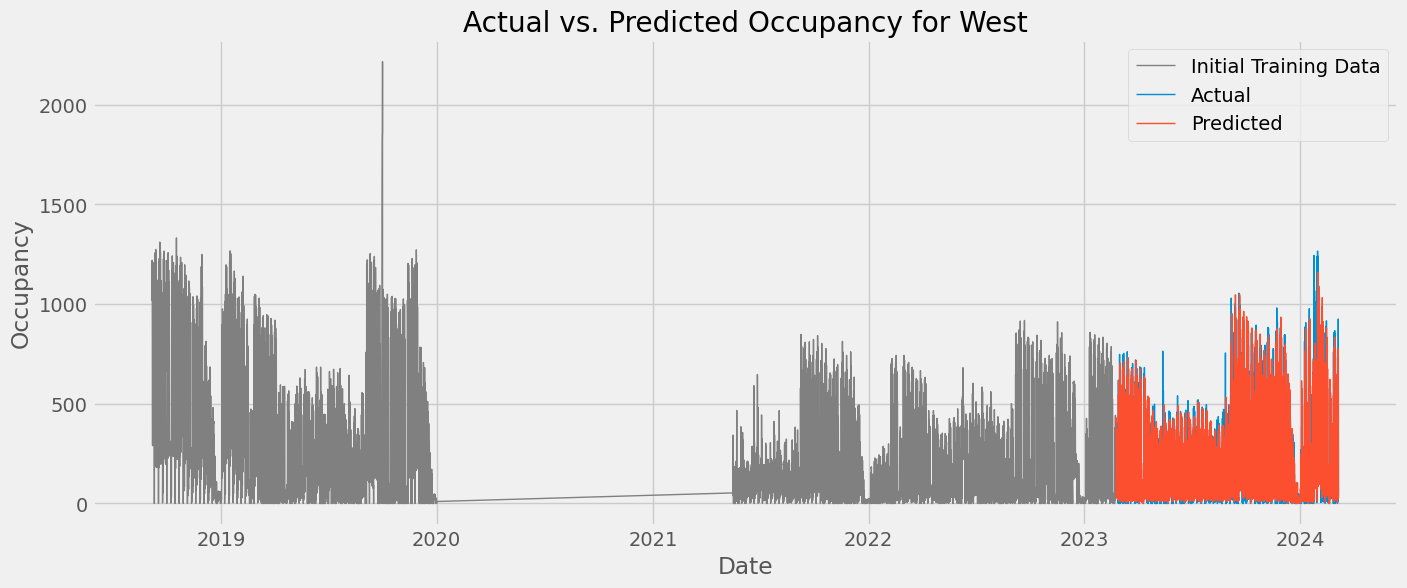

In [274]:
# Create figure
plt.figure(figsize=(15, 6))

# Plot the initial training data
plt.plot(train.index, train['Occupancy'], label='Initial Training Data', color='gray', linewidth=1)

# Plot for the actual and predicted values
plt.plot(actual_vs_pred_df.index, actual_vs_pred_df['Actual'], label='Actual', linewidth=1)
plt.plot(actual_vs_pred_df.index, actual_vs_pred_df['Predicted'], label='Predicted', linewidth=1)

# Plot labels and title
plt.xlabel('Date')
plt.ylabel('Occupancy')
plt.title(f'Actual vs. Predicted Occupancy for {parking_lot_to_predict}')

# Show legend
plt.legend()

# Show plot
plt.show()


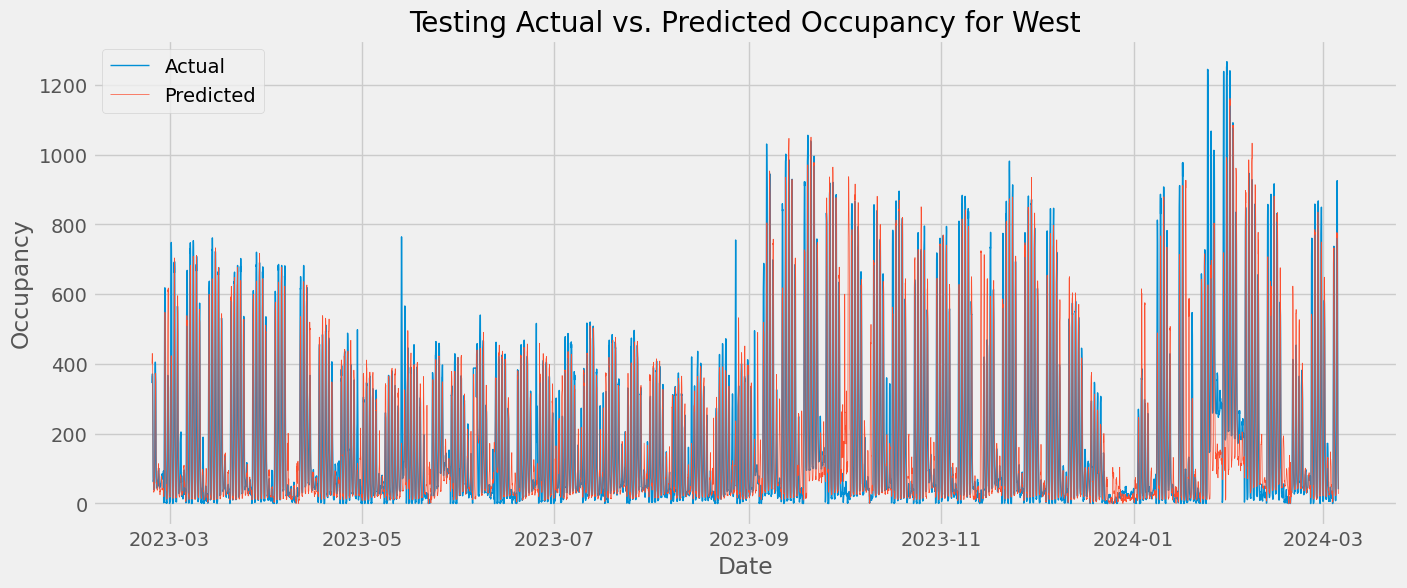

In [275]:
# Filter actual_vs_pred_df to include only the testing period
testing_actual_vs_pred_df = actual_vs_pred_df.loc[y_test.index]

# Create figure
plt.figure(figsize=(15, 6))

# Plot for the actual and predicted values during the testing period
plt.plot(testing_actual_vs_pred_df.index, testing_actual_vs_pred_df['Actual'], label='Actual', linewidth=1)
plt.plot(testing_actual_vs_pred_df.index, testing_actual_vs_pred_df['Predicted'], label='Predicted', linewidth=0.5)

# Plot labels and title
plt.xlabel('Date')
plt.ylabel('Occupancy')
plt.title(f'Testing Actual vs. Predicted Occupancy for {parking_lot_to_predict}')

# Show legend
plt.legend()

# Show plot
plt.show()


In [276]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Extract actual and predicted values
actual_values = testing_actual_vs_pred_df['Actual']
predicted_values = testing_actual_vs_pred_df['Predicted']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)

# Calculate MSE
mse = mean_squared_error(actual_values, predicted_values)

# Calculate R-squared
r2 = r2_score(actual_values, predicted_values)

print("ERRORS_SHOWN")

print("RMSE:", rmse)
print("MAE:", mae)
print("MSE:", mse)
print("R-squared:", r2)


ERRORS_SHOWN
RMSE: 81.32511932791326
MAE: 41.83183097303518
MSE: 6613.775033699331
R-squared: 0.8726614071813961


In [277]:
import plotly.graph_objects as go


# Create a new figure
fig = go.Figure()

# Add trace for the initial training data
fig.add_trace(go.Scatter(x=train.index, y=train['Occupancy'],
                         name='Initial Training Data',
                         line=dict(color='gray', width=1),
                         hovertemplate='<b>Date</b>: %{x|%m-%d-%Y}<br>' +
                                       '<b>Occupancy</b>: %{y}<br>' +
                                       '<b>Day of Week</b>: %{x| %A}<extra></extra>'))


# Update layout
fig.update_layout(
    title=f'Comparison of Predicted and Actual Parking Occupancy for {parking_lot_to_predict}',
    xaxis=dict(
        rangeslider=dict(visible=True),
        type='date'
    ),
    yaxis_title='Occupancy',
    template='plotly_white',
)

# Update axes appearance
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')

# Show the plot
fig.show()


In [278]:
import plotly.graph_objects as go


# Create a new figure
fig = go.Figure()


# Add trace for the actual values
fig.add_trace(go.Scatter(x=testing_actual_vs_pred_df.index, y=testing_actual_vs_pred_df['Actual'],
                         name='Actual Parking Occupancy',
                         line=dict(color='blue', width=0.5),
                         hovertemplate='<b>Date</b>: %{x|%m-%d-%Y}<br>' +
                                       '<b>Actual Occupancy</b>: %{y}<br>' +
                                       '<b>Day of Week</b>: %{x| %A}<extra></extra>'))


# Add trace for the predicted values
fig.add_trace(go.Scatter(x=testing_actual_vs_pred_df.index, y=testing_actual_vs_pred_df['Predicted'],
                         name='Predicted Parking Occupancy',
                         line=dict(color='red', width=0.5),
                         hovertemplate='<b>Date</b>: %{x|%m-%d-%Y}<br>' +
                                       '<b>Predicted Occupancy</b>: %{y}<br>' +
                                       '<b>Day of Week</b>: %{x| %A}<extra></extra>'))


# Update layout
fig.update_layout(
    title=f'Comparison of Predicted and Actual Parking Occupancy for {parking_lot_to_predict}',
    xaxis=dict(
        rangeslider=dict(visible=True),
        type='date'
    ),
    yaxis_title='Occupancy',
    template='plotly_white',
    annotations=[
        dict(xref='paper', yref='paper', x=0.5, y=0.9,
             text=f'RMSE: {rmse:.2f}', showarrow=False),
        dict(xref='paper', yref='paper', x=0.5, y=0.85,
             text=f'MAE: {mae:.2f}', showarrow=False),
        dict(xref='paper', yref='paper', x=0.5, y=0.8,
             text=f'MSE: {mse:.2f}', showarrow=False),
        dict(xref='paper', yref='paper', x=0.5, y=0.75,
             text=f'R-squared: {r2:.2f}', showarrow=False)
    ]
)

# Update axes appearance
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey')

# Show the plot
fig.show()


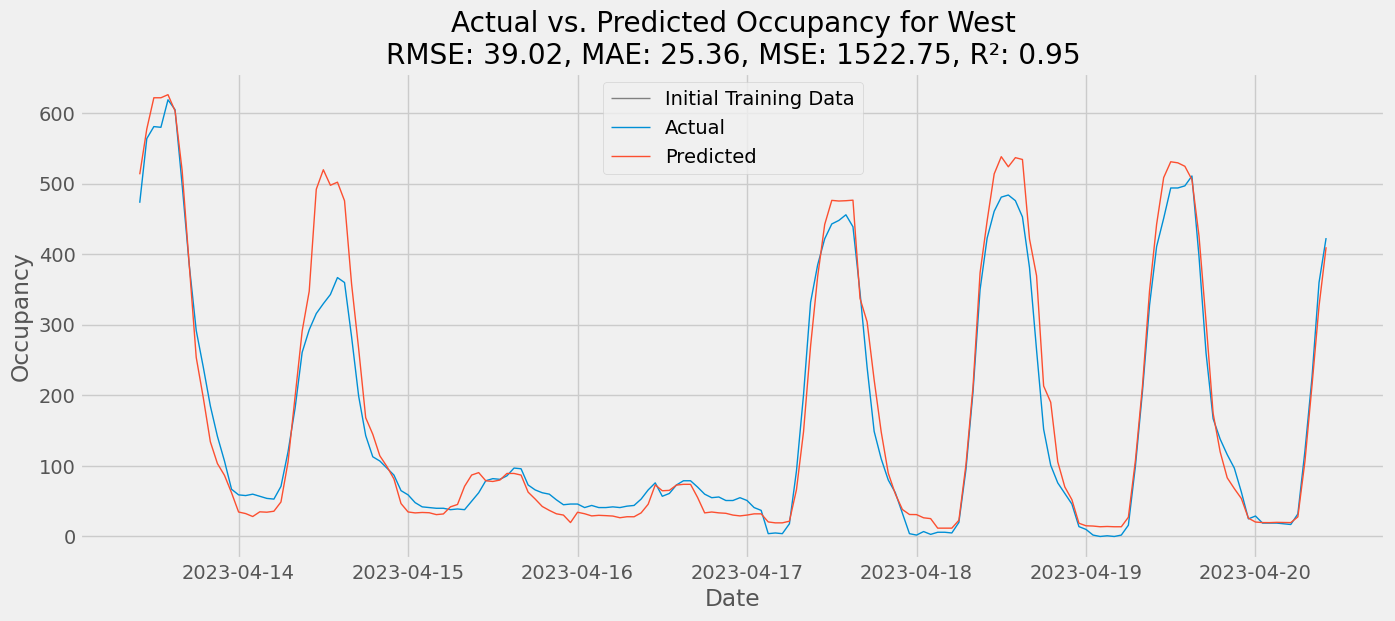

In [279]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure y_test has a DateTimeIndex
start_date = y_test.index.min()
end_date = y_test.index.max()

# Select a random start date within the y_test date range, ensuring there's room for 2 days after it
random_start_date = start_date + pd.to_timedelta(np.random.randint(0, (end_date - start_date).days - 1), unit='D')
random_end_date = random_start_date + pd.Timedelta(days=7)

# Filter the dataframes based on the 2-day range
train_filtered = train.loc[(train.index >= random_start_date) & (train.index <= random_end_date)]
actual_vs_pred_filtered = actual_vs_pred_df.loc[(actual_vs_pred_df.index >= random_start_date) & (actual_vs_pred_df.index <= random_end_date)]

# Ensure alignment of actual and predicted values
actual_vs_pred_filtered = actual_vs_pred_filtered.dropna(subset=['Actual', 'Predicted'])

# Calculate errors
actual = actual_vs_pred_filtered['Actual']
predicted = actual_vs_pred_filtered['Predicted']

mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual, predicted)
r2 = r2_score(actual, predicted)

# Create figure
plt.figure(figsize=(15, 6))

# Plot the initial training data
plt.plot(train_filtered.index, train_filtered['Occupancy'], label='Initial Training Data', color='gray', linewidth=1)

# Plot for the actual and predicted values
plt.plot(actual_vs_pred_filtered.index, actual_vs_pred_filtered['Actual'], label='Actual', linewidth=1)
plt.plot(actual_vs_pred_filtered.index, actual_vs_pred_filtered['Predicted'], label='Predicted', linewidth=1)

# Plot labels and title
plt.xlabel('Date')
plt.ylabel('Occupancy')
plt.title(f'Actual vs. Predicted Occupancy for {parking_lot_to_predict}\n'
          f'RMSE: {rmse:.2f}, MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}')

# Show legend
plt.legend()

# Show plot
plt.show()


In [280]:
actual_vs_pred_df

,Actual,Predicted
date,,
2023-02-23 10:00:00,345,400.544298
2023-02-23 11:00:00,364,421.638340
2023-02-23 12:00:00,365,429.878198
2023-02-23 13:00:00,371,421.638340
2023-02-23 14:00:00,371,423.801606
...,...,...
2024-03-05 19:00:00,232,239.569107
2024-03-05 20:00:00,146,156.372319
2024-03-05 21:00:00,88,98.162692


In [281]:
# Record the end time
end_time = time.time()

# Calculate the total run time
total_run_time = end_time - start_time
print("Total run time:", total_run_time, "seconds")

Total run time: 4.897381782531738 seconds


In [282]:
"""
# Retrain on all the data
df = create_features(df)

TARGET = 'Occupancy'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = lgb.LGBMRegressor(boosting_type='gbdt',
                        n_estimators=5000,
                        early_stopping_rounds=150,
                        objective='regression',
                        max_depth=5,
                        min_child_samples=1,
                        learning_rate=0.05,
                        colsample_bytree=0.91,
                        subsample=0.5,
                        reg_lambda=0.2)

reg.fit(X_all, y_all, eval_set=[(X_all, y_all)])
"""

"\n# Retrain on all the data\ndf = create_features(df)\n\nTARGET = 'Occupancy'\n\nX_all = df[FEATURES]\ny_all = df[TARGET]\n\nreg = lgb.LGBMRegressor(boosting_type='gbdt',\n                        n_estimators=5000,\n                        early_stopping_rounds=150,\n                        objective='regression',\n                        max_depth=5,\n                        min_child_samples=1,\n                        learning_rate=0.05,\n                        colsample_bytree=0.91,\n                        subsample=0.5,\n                        reg_lambda=0.2)\n\nreg.fit(X_all, y_all, eval_set=[(X_all, y_all)])\n"

In [283]:
first_date_time = df.iloc[0]['date']
last_date_time = df.iloc[-1]['date']
#print(last_date_time)

new_date_time = last_date_time + pd.DateOffset(months=3)
#print(new_date_time)

first_date_time_str = first_date_time.strftime('%Y-%m-%d %H:%M:%S')
last_date_time_str = last_date_time.strftime('%Y-%m-%d %H:%M:%S')
new_date_time_str = new_date_time.strftime('%Y-%m-%d %H:%M:%S')
print(first_date_time_str)
print(last_date_time_str)
#print(new_date_time_str)

2018-09-06 10:00:00
2024-03-05 23:00:00


In [284]:
import pandas as pd

def update_features_for_date(df, date):
    """
    Create time series features for a specific date from the datetime index.
    """
    df['date'] = df.index
    
    # Create a dictionary to hold the new feature values for the specific date
    new_features = {}
    new_features['month'] = date.month
    new_features['day_of_year'] = date.dayofyear
    new_features['day_of_week'] = date.dayofweek
    new_features['hour'] = date.hour  # Add hour feature

    df['year'] = df['date'].dt.year
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['date'].dt.is_month_end.astype(int)
    
    # Seasonality features
    df['sin_day'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
    df['cos_day'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)
    df['sin_week'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['cos_week'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

    # Seasonal indices (if applicable)
    # Autoregressive features (if applicable)
    # Time since last event (if applicable)
    # Day/night indicator
    df['is_day'] = np.where((df['hour'] >= 6) & (df['hour'] <= 18), 1, 0)
    
    # Weekend/weekday indicator
    df['is_weekend'] = df.date.dt.weekday // 4
    
    # Month of year
    df['month_of_year'] = df['date'].dt.month
    
    # Quarter of year
    df['quarter_of_year'] = df['date'].dt.quarter
    
    # Day/night duration
    df['day_duration'] = np.where(df['is_day'] == 1, 12 - df['hour'], 0)
    df['night_duration'] = np.where(df['is_day'] == 0, df['hour'], 0)

def update_rolling_features_for_date(df, date):
    df['date'] = df.index
    
    # Calculate the rolling window size and ensure we have enough data points
    window_size = 7  # 7-day rolling window
    past_window = df.loc[:date].tail(window_size)
    
    if len(past_window) < window_size:
        raise ValueError("Not enough data points in the past window to calculate rolling features.")
    
    new_features = {}
    # Rolling features based on past window
    new_features['rolling_min'] = float(past_window['Occupancy'].min())
    new_features['rolling_max'] = float(past_window['Occupancy'].max())
    new_features['rolling_sum'] = float(past_window['Occupancy'].sum())
    new_features['rolling_mean'] = float(past_window['Occupancy'].mean())
    new_features['rolling_median'] = float(past_window['Occupancy'].median())
    new_features['rolling_std'] = float(past_window['Occupancy'].std())
    new_features['rolling_quantile_25'] = float(past_window['Occupancy'].quantile(0.25))
    new_features['rolling_quantile_75'] = float(past_window['Occupancy'].quantile(0.75))
    
    # Update the DataFrame at the specific date index
    for feature, value in new_features.items():
        df.loc[date, feature] = value

In [285]:
def update_lags_for_date(df, date):
    """
    Create time lags for added time series features for a given date and allow the model to learn the temporal structure of the data.
    """
    target_map = df['Occupancy'].to_dict()

    # Create a dictionary to hold the lag features for the specific date
    lag_features = {}
    """
    lag_features['lag_1_hour'] = float(target_map.get(date - pd.Timedelta('1 hours'), None))
    lag_features['lag_2_hours'] = float(target_map.get(date - pd.Timedelta('2 hours'), None))
    lag_features['lag_3_hours'] = float(target_map.get(date - pd.Timedelta('3 hours'), None))
    """

    """
    lag_features['lag_7_days'] = float(target_map.get(date - pd.Timedelta('7 days'), None))
    lag_features['lag_14_days'] = float(target_map.get(date - pd.Timedelta('14 days'), None))
    lag_features['lag_21_days'] = float(target_map.get(date - pd.Timedelta('21 days'), None))
    lag_features['lag_28_days'] = float(target_map.get(date - pd.Timedelta('28 days'), None))
    lag_features['lag_30_days'] = float(target_map.get(date - pd.Timedelta('30 days'), None))
    lag_features['lag_35_days'] = float(target_map.get(date - pd.Timedelta('35 days'), None))
    lag_features['lag_42_days'] = float(target_map.get(date - pd.Timedelta('42 days'), None))
    lag_features['lag_49_days'] = float(target_map.get(date - pd.Timedelta('49 days'), None))
    lag_features['lag_56_days'] = float(target_map.get(date - pd.Timedelta('56 days'), None))
    lag_features['lag_60_days'] = float(target_map.get(date - pd.Timedelta('60 days'), None))
    """

    for lag_days in range(1, 20):  # lags for 1 to 6 days
        lag_features[f'lag_{lag_days * 7}_days'] = float(target_map.get(date - pd.Timedelta(f'{lag_days * 7} days'), None))

    
    # Daily lags
    for lag_days in range(1, 7):  # lags for 1 to 6 days
        lag_features[f'lag_{lag_days}_days'] = float(target_map.get(date - pd.Timedelta(f'{lag_days} days'), None))
        
    
    # Update the DataFrame at the specific date index
    for feature, value in lag_features.items():
        df.loc[date, feature] = value

# Example usage:
# date_time = pd.Timestamp('2023-12-14 22:00:00')  # Replace with your specific datetime
# updated_df = update_lags_for_date(something_df, date_time)

In [286]:
train_size = 0.75
new_train, new_test = train_test_split(df, test_size=(1 - train_size), shuffle=False)
old_test= new_test.copy()

# Define rolling calculation columns and time lag data columns to be cleaned
rolling_calculation_columns = [col for col in new_test.columns if 'rolling' in col]  # Example: Identify rolling calculation columns
time_lag_columns = [col for col in new_test.columns if 'lag' in col]  # Example: Identify time lag data columns
occupancy_column = [col for col in new_test.columns if 'Occupancy' in col]  # Example: Identify occupancy data columns

# Iterate over rolling calculation columns and set data to NaN
for col in rolling_calculation_columns:
    new_test[col] = np.nan

# Iterate over time lag data columns and set data to NaN
for col in time_lag_columns:
    new_test[col] = np.nan

# Iterate over occupancy columns and set data to NaN
for occ in occupancy_column:
    new_test[occ] = np.nan

something_df = pd.concat([new_train, new_test])

In [287]:
start_ind_time = new_train.iloc[-1]['date']
end_ind_time = new_test.iloc[-1]['date']

print(start_ind_time, end_ind_time)

2023-02-23 09:00:00 2024-03-05 23:00:00


In [288]:

"""
# Create a date range from last_date_time to new_date_time
date_range = pd.date_range(start=start_ind_time, end=end_ind_time, freq='H')  # 'D' represents day frequency
for date_time in date_range:
    
    update_features_for_date(something_df, date_time)
    #update_rolling_features_for_date(something_df, date_time)
    update_lags_for_date(something_df, date_time)

        # Assuming 'row_data' contains the data for the single row you want to predict
        # 'row_data' should be a pandas Series or DataFrame with the same columns as your training data
    row_data = something_df[something_df.index == date_time].iloc[0]  # Example: selecting the first row from the test data
        # List of features to exclude
    features_to_exclude = ["Occupancy", "date"]  # Add the names of features you want to exclude

        # Filtering out excluded features
    filtered_row_data = row_data.drop(features_to_exclude, inplace=False)  # inplace=False ensures row_data remains unchanged

        # Extracting the features from the filtered row data
    X_single = filtered_row_data[FEATURES].values.reshape(1, -1)  # Reshaping to a 2D array as expected by the model

    filtered_row_data = pd.DataFrame([filtered_row_data])
    predicted_occupancy = reg.predict(filtered_row_data)
        # Extract the predicted occupancy value from the array
    predicted_occupancy_value = predicted_occupancy[0]

    print(predicted_occupancy_value)

        # Assign predicted occupancy to the 'Occupancy' column of the row with index 'last_date_time'
    something_df.loc[date_time, 'Occupancy'] = predicted_occupancy_value
    row_data = something_df[something_df.index == date_time].iloc[0]
    """

'\n# Create a date range from last_date_time to new_date_time\ndate_range = pd.date_range(start=start_ind_time, end=end_ind_time, freq=\'H\')  # \'D\' represents day frequency\nfor date_time in date_range:\n    \n    update_features_for_date(something_df, date_time)\n    #update_rolling_features_for_date(something_df, date_time)\n    update_lags_for_date(something_df, date_time)\n\n        # Assuming \'row_data\' contains the data for the single row you want to predict\n        # \'row_data\' should be a pandas Series or DataFrame with the same columns as your training data\n    row_data = something_df[something_df.index == date_time].iloc[0]  # Example: selecting the first row from the test data\n        # List of features to exclude\n    features_to_exclude = ["Occupancy", "date"]  # Add the names of features you want to exclude\n\n        # Filtering out excluded features\n    filtered_row_data = row_data.drop(features_to_exclude, inplace=False)  # inplace=False ensures row_data rem

In [289]:
"""
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

num_count = 3

# Select data between start_ind_time and start_ind_time_a
selected_data = something_df.loc[(something_df.index >= date_time) & (something_df.index <= date_time + pd.DateOffset(months = num_count))]
old_test_formatted = old_test.loc[(old_test.index >= date_time) & (old_test.index <= date_time + pd.DateOffset(months = num_count))]

# Plot the 'Occupancy' column
plt.figure(figsize=(10, 6))  # Adjust size as needed
plt.plot(old_test_formatted.index, old_test_formatted['Occupancy'], linestyle='-', linewidth=0.2, color='blue', label='Old Test')
plt.plot(selected_data.index, selected_data['Occupancy'], linestyle='-', linewidth=0.2, color='red', label='Selected Data')

# Format the x-axis with date format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.title('Occupancy between {} and {}'.format(start_ind_time, date_time + pd.DateOffset(weeks = 1)))
plt.xlabel('Date')
plt.ylabel('Occupancy')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()
plt.show()
"""

"\nimport matplotlib.pyplot as plt\nimport matplotlib.dates as mdates\n\nnum_count = 3\n\n# Select data between start_ind_time and start_ind_time_a\nselected_data = something_df.loc[(something_df.index >= date_time) & (something_df.index <= date_time + pd.DateOffset(months = num_count))]\nold_test_formatted = old_test.loc[(old_test.index >= date_time) & (old_test.index <= date_time + pd.DateOffset(months = num_count))]\n\n# Plot the 'Occupancy' column\nplt.figure(figsize=(10, 6))  # Adjust size as needed\nplt.plot(old_test_formatted.index, old_test_formatted['Occupancy'], linestyle='-', linewidth=0.2, color='blue', label='Old Test')\nplt.plot(selected_data.index, selected_data['Occupancy'], linestyle='-', linewidth=0.2, color='red', label='Selected Data')\n\n# Format the x-axis with date format\nplt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))\nplt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())\n\nplt.title('Occupancy between {} and {}'.format(start_

In [290]:
"""
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ensure the DataFrames are aligned by index
aligned_data = old_test_formatted.align(selected_data, join='inner', axis=0)

# Extract the 'Occupancy' columns from both DataFrames
y_true = aligned_data[0]['Occupancy']
y_pred = aligned_data[1]['Occupancy']

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Print the metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2}")

"""

'\nimport pandas as pd\nimport numpy as np\nfrom sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score\n\n# Ensure the DataFrames are aligned by index\naligned_data = old_test_formatted.align(selected_data, join=\'inner\', axis=0)\n\n# Extract the \'Occupancy\' columns from both DataFrames\ny_true = aligned_data[0][\'Occupancy\']\ny_pred = aligned_data[1][\'Occupancy\']\n\n# Calculate metrics\nmse = mean_squared_error(y_true, y_pred)\nrmse = np.sqrt(mse)\nmae = mean_absolute_error(y_true, y_pred)\nr2 = r2_score(y_true, y_pred)\n\n# Print the metrics\nprint(f"RMSE: {rmse}")\nprint(f"MAE: {mae}")\nprint(f"MSE: {mse}")\nprint(f"R²: {r2}")\n\n'

In [291]:
# Get feature importances
feature_importances = reg.feature_importances_

# Get feature names
feature_names = reg.feature_name_

# Print feature importances and names
for name, importance in zip(feature_names, feature_importances):
    print(name, ":", importance)


temp : 97
visibility : 20
dew_point : 70
feels_like : 36
pressure : 74
humidity : 81
wind_speed : 14
clouds_all : 37
rain_1h : 18
snow_1h : 19
term_date : 19
is_holiday : 129
day_of_week : 170
month : 23
day_of_year : 125
week_of_year : 26
hour : 69
weighted_day_of_year : 18
year : 16
is_month_start : 13
is_month_end : 5
sin_day : 230
cos_day : 66
sin_week : 79
cos_week : 9
sin_month : 27
cos_month : 8
is_day : 18
is_weekend : 0
month_of_year : 0
quarter_of_year : 0
day_duration : 31
night_duration : 4
lag_7_days : 235
lag_14_days : 109
lag_21_days : 61
lag_28_days : 55
lag_35_days : 64
lag_42_days : 81
lag_49_days : 64
lag_56_days : 73
lag_63_days : 53
lag_70_days : 49
lag_77_days : 29
lag_84_days : 26
lag_91_days : 30
lag_98_days : 39
lag_105_days : 28
lag_112_days : 29
lag_119_days : 44
lag_126_days : 29
lag_133_days : 24
lag_1_days : 412
lag_2_days : 62
lag_3_days : 88
lag_4_days : 85
lag_5_days : 98
lag_6_days : 113


In [292]:
feature_importances = reg.feature_importances_

# Create a DataFrame to store the feature importances
feature_importance = pd.DataFrame(data=feature_importances, index=X_train.columns, columns=['importance'])

# Print the DataFrame
print(feature_importance)

                      importance
temp                          97
visibility                    20
dew_point                     70
feels_like                    36
pressure                      74
humidity                      81
wind_speed                    14
clouds_all                    37
rain_1h                       18
snow_1h                       19
term_date                     19
is_holiday                   129
day_of_week                  170
month                         23
day_of_year                  125
week_of_year                  26
hour                          69
weighted_day_of_year          18
year                          16
is_month_start                13
is_month_end                   5
sin_day                      230
cos_day                       66
sin_week                      79
cos_week                       9
sin_month                     27
cos_month                      8
is_day                        18
is_weekend                     0
month_of_y

In [293]:
X_train.columns

Index(['temp', 'visibility', 'dew_point', 'feels_like', 'pressure', 'humidity',
       'wind_speed', 'clouds_all', 'rain_1h', 'snow_1h', 'term_date',
       'is_holiday', 'day_of_week', 'month', 'day_of_year', 'week_of_year',
       'hour', 'weighted_day_of_year', 'year', 'is_month_start',
       'is_month_end', 'sin_day', 'cos_day', 'sin_week', 'cos_week',
       'sin_month', 'cos_month', 'is_day', 'is_weekend', 'month_of_year',
       'quarter_of_year', 'day_duration', 'night_duration', 'lag_7_days',
       'lag_14_days', 'lag_21_days', 'lag_28_days', 'lag_35_days',
       'lag_42_days', 'lag_49_days', 'lag_56_days', 'lag_63_days',
       'lag_70_days', 'lag_77_days', 'lag_84_days', 'lag_91_days',
       'lag_98_days', 'lag_105_days', 'lag_112_days', 'lag_119_days',
       'lag_126_days', 'lag_133_days', 'lag_1_days', 'lag_2_days',
       'lag_3_days', 'lag_4_days', 'lag_5_days', 'lag_6_days'],
      dtype='object')

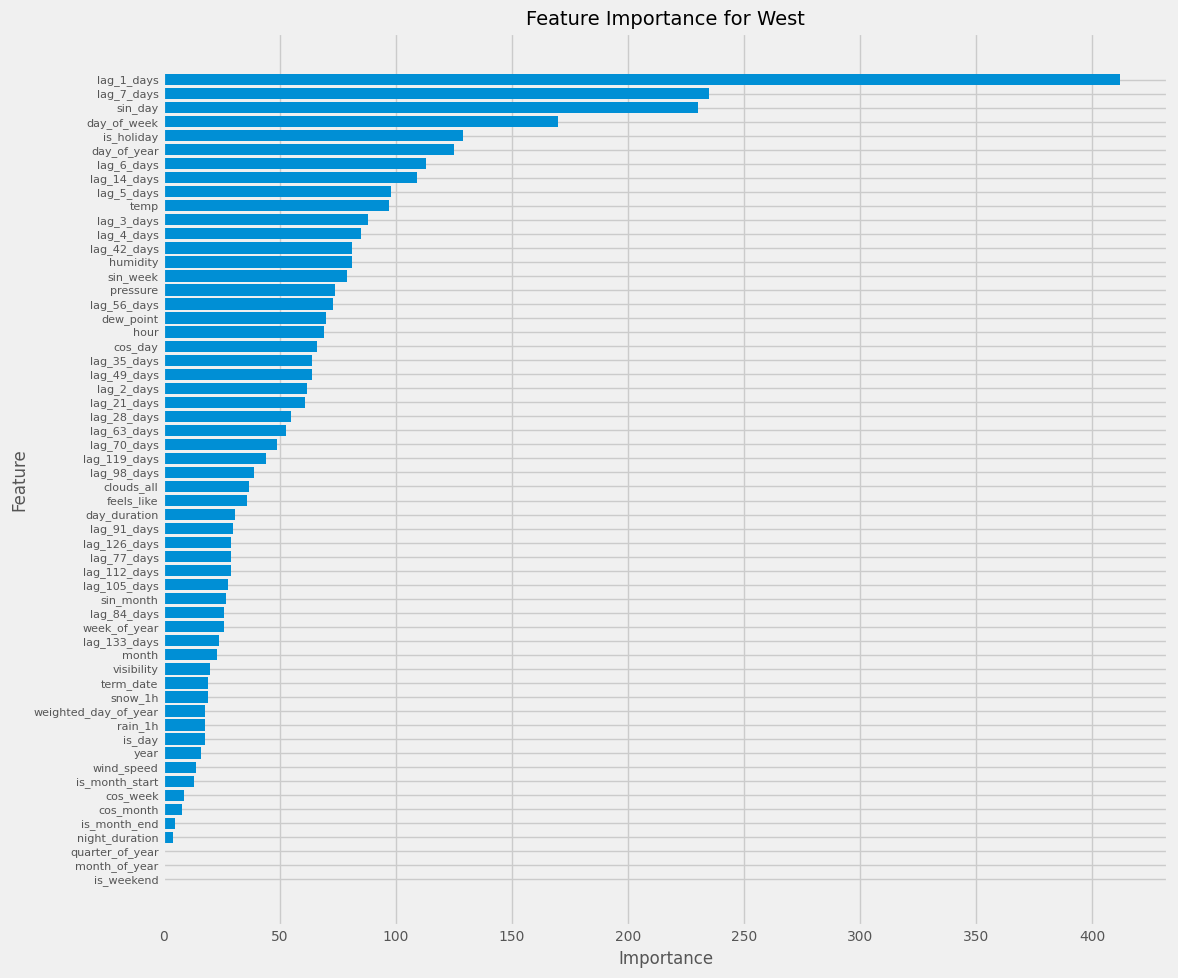

In [294]:
import matplotlib.pyplot as plt

# Sort the feature importances in ascending order
sorted_feature_importance = feature_importance.sort_values('importance')

# Plot the sorted feature importances
plt.figure(figsize=(12, 10))
barplot = plt.barh(sorted_feature_importance.index, sorted_feature_importance['importance'])

# Adjust font size for each y-axis label individually
for tick in plt.gca().get_yticklabels():
    tick.set_fontsize(8)

plt.xlabel('Importance', fontsize=12)  # Adjust font size for x-label
plt.ylabel('Feature', fontsize=12)  # Adjust font size for y-label
plt.title(f'Feature Importance for {parking_lot_to_predict}', fontsize=14)  # Adjust font size for title
# Adjust font size for x-axis ticks
plt.xticks(fontsize=10)

plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()
